# **Theory or why ResNet?**
> Although it is not obvious,accuracy of newral network decreases with the increase of number of layers (image from original ResNet article)
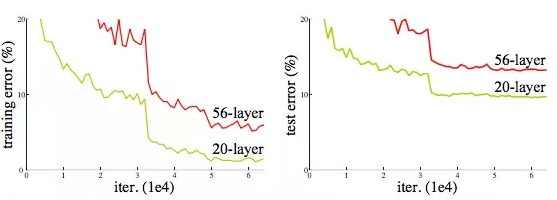

> It may be thought that increasing number of layers allows to catch all possible features and minimize the error, but the result turns out to be totally contrary. This may be explained by comparing two NNs - one shallow and one deeper.NN
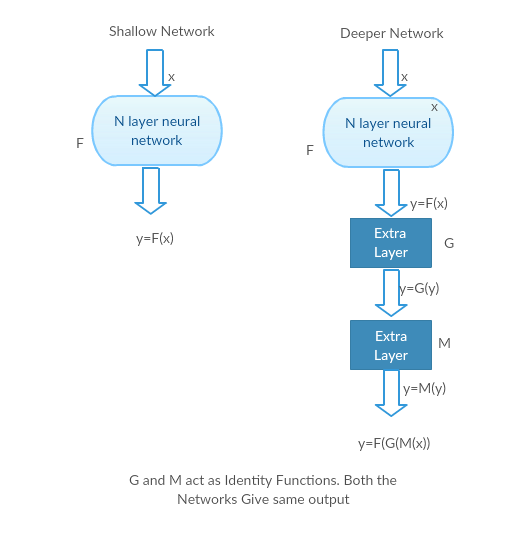
There are two scenarios - worst case (early layers may be replaced with shallow network and last two act as identity layers y = G(y) = M(y)) and better case scenario (additional layers help to approximate the mapping and reduces error).  In the worst case scenario, both the shallow network and deeper variant of it should give the same accuracy. In the rewarding scenario case, the deeper model should give better accuracy than it’s shallower counter part. On real experiments it turns out that the error is not reduced. 

>Solution: instead of learning how to map x->y with some kind of function H(x) (output from stacked non-linear layers), residual function F(x) = H(x) - x is defined, wich results in H(x) = F(x) + x, the composition of output from stacked non-linear layers and identity function (see image below: ResNet block) 
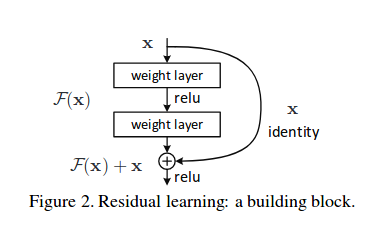


> The logic behind the solution of this problem can be seen in the image below, as it is easier to get F(x) = 0 than to get the identity mapping/
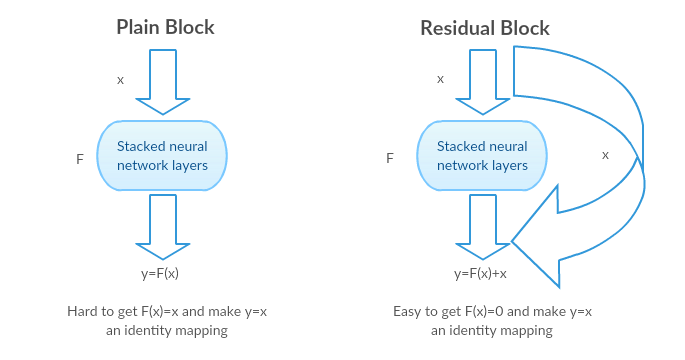

## Step 1 - importing necessary libraries, dataset and preparing it for further work

In [ ]:
# importing necessary libraries
from typing import List # importing type alias
import logging #event logging
from typing import Optional # optional data type
from functools import partial # enables partial function application
from typing import Tuple # tuple with specified types of contents
from typing import Union # specifie which types may be used
import torch.nn as nn # neural network package
import numpy as np #math
import os # os functions
import pandas as pd # data analysis
import torch # ML
from torch.optim import Adam # optimization first-order gradient-based optimization of stochastic objective functions
from torchvision.models.resnet import BasicBlock # Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
from torchvision.models import resnet18, vgg16 # pre-made models to compare
from torch.utils.data import DataLoader # iterable over dataset
from torch.utils.data import Dataset # abstract class representing dataset
from PIL import Image # image class
from matplotlib import pyplot as plt # graphics
from torchvision.models.resnet import ResNet # deep residual networks pre-trained on ImageNet
from sklearn.metrics import roc_auc_score # get roc auc score
from torch import Tensor # multi-dimensional matrix
from torchvision import transforms # image transformations
from torch.autograd import Variable # Tensor wrapper, represents a node in a computational graph
import albumentations as A # image augmentation

In [ ]:
# import data, check if GPU is on
DATA_FOLDER = '../input/histopathologic-cancer-detection' #importing data
LABELS = f'{DATA_FOLDER}/train_labels.csv'
TRAIN_IMAGES_FOLDER = f'{DATA_FOLDER}/train'
SAMPLE_SUBMISSION = f'{DATA_FOLDER}/sample_submission.csv'
USE_GPU = torch.cuda.is_available()

In [ ]:
USE_GPU

In [ ]:
# df with assigned image ids to labels
labels = pd.read_csv(LABELS)
# lets see total number of examples of each class
print(labels['label'].value_counts())

### Substep - perform data augmentation

> What actually is image augmentation? this technique helps to artificially expand given dataset if the amount of data given is too small or all images are pretty simmilar. This may be achieved by turning, zooming, blurring images, adding noise, saturations and changing colors.

In [ ]:
# get full path to images from ladels df
def format_path_to_images_for_dataset(labels, path):
    return [os.path.join(path, f'{f}.tif') for f in labels['id'].values]
# reformat labels
def format_labels_for_data_set(labels):
    return (labels['label'].values.reshape(-1,1))

In [ ]:
# initialize datasets using methods from GPU notebook as example
# full dataset of images and labels
class MainDataset(Dataset):
    # intialize dataset, x_dataset - images, y_dataset - labels, x_tmfs - transformation
    def __init__(self, x_dataset, y_dataset, x_tfms):
        self.x_dataset = x_dataset
        self.y_dataset = y_dataset
        self.x_tfms = x_tfms
    # return length of dataset
    def __len__(self):
        return self.x_dataset.__len__() 
    # return item by index
    def __getitem__(self, index):
        x = self.x_dataset[index]
        y = self.y_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x, y

# class of image dataset
class ImageDataset(Dataset):
    # initialize dataset
    def __init__(self, path_to_image, aug_pipeline=None):
        self.path_to_image = path_to_image
        self.aug_pipeline = aug_pipeline
    # return length of dataset
    def __len__(self):
        return len(self.path_to_image)
    # return image with albumentations performed 
    def __getitem__(self, index):
        img = Image.open(self.path_to_image[index])
        if self.aug_pipeline == None:
            self.aug_pipeline = A.Compose([A.HorizontalFlip(p = 0)]) # for the test if no image agumentations is not performed
        image_aug = self.aug_pipeline(image = np.array(img))['image']
        image = Image.fromarray(image_aug, 'RGB') #return image
        return image
    
#class of labels dataset
class LabelDataset(Dataset):
    # intitialize dataset
    def __init__(self, labels):
        self.labels = labels
    # dataset length
    def __len__(self):
        return len(labels)
    #return item from labels dataset by index
    def __getitem__(self, index):
        return self.labels[index]

In [ ]:
# perform split to train and validation dataset, take equal numbers of exzmples for each class
def split(df, split=0.2, samples=5000):
    # df - dataframe to get data from, split - validation proportion, samples - number of samples for each class
    class_0 = df.loc[df['label'] == 0]
    class_1 = df.loc[df['label'] == 1]
    class_0 = class_0.sample(n=samples)
    class_1 = class_1.sample(n=samples)
    tot_split = int(samples * split)
    valid = [class_0.iloc[:tot_split], class_1.iloc[:tot_split]]
    valid = pd.concat(valid)
    train = [class_0.iloc[tot_split:], class_1.iloc[tot_split:]]
    train = pd.concat(train)
    return train, valid

In [ ]:
# working on dataset
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)

In [ ]:
# set augmentation for images
# p - probability
aug_pipeline_real = A.Compose([
        A.RandomRotate90(p = 0.3), # randomly rotate image by 90 degrees 0, 1, 2... times (p is probability of applying)
        A.Flip(p = 0.3), #Flip the input either horizontally, vertically or both horizontally and vertically
        A.Transpose(p = 0.1), # Transpose image
        A.GaussNoise(p = 0.2),
        A.OneOf([ # blur image
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.1),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2), #perform randomly affine transformations
        A.OneOf([ # give the image distortion
            A.OpticalDistortion(p=0.1),
            A.GridDistortion(p=0.1),
        ], p=0.1),
        A.HueSaturationValue(p=0.3),#randomly change hue, saturation and value
    ], p=0.5) # probability to apply


In [ ]:
# getting train and validation datasets, getting image datasets and labels dataset
train, valid = split(labels)
train_labels = format_labels_for_data_set(train)
valid_labels = format_labels_for_data_set(valid)
train_images = format_path_to_images_for_dataset(train, TRAIN_IMAGES_FOLDER)
valid_images = format_path_to_images_for_dataset(valid, TRAIN_IMAGES_FOLDER)
train_images_dataset = ImageDataset(train_images, aug_pipeline_real)
valid_images_dataset = ImageDataset(valid_images, aug_pipeline_real)
train_labels_dataset = LabelDataset(train_labels)
valid_labels_dataset = LabelDataset(valid_labels)
train_images_dataset_no_aug = ImageDataset(train_images, None)
valid_images_dataset_no_aug = ImageDataset(valid_images, None)


In [ ]:
# modified from GPU notebook
def implot(dataset, labels, w=2, h=2, cols=9):
    # plot how 2 images with label 1 and label 0 of dataset may be trasformed after augmentation
    idx_1 = np.where(labels == 1)[0][0]
    idx_0 = np.where(labels == 0)[0][0]
    rows = 2
    images = [dataset[idx_1] for i in range(cols)] + [dataset[idx_0] for i in range(cols)]
    print('First row is cancer, second - no cancer')
    fig = plt.figure(figsize = (cols * w, rows * h))
    for chart, img in enumerate(images, 1):
        ax = plt.subplot(rows, cols, chart)
        ax.imshow(np.array(img))
        ax.axis('off')
    fig.tight_layout()
    plt.show()
implot(train_images_dataset, train_labels)

> Althoug standard image mean of each channel and std of image channel may be used, mean and std may be calculated for this case, as it may differ

In [ ]:
# find mean and std for each of 3 channels in images
shuffle = True
batch_sz = 100
x_tfms = transforms.Compose([transforms.ToTensor()])
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
loader = DataLoader(train_dataset, batch_size=batch_sz, num_workers=0, shuffle=shuffle)
# from internet
mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*96*96))
# image size 96 * 96

In [ ]:
# mean and std to list to use in normalize
mean = [mean[i].item() for i in range(len(mean))]
std = [std[i].item() for i in range(len(std))]

In [ ]:
# dataloader - main utility to load data in pytorch
batch_size = 50
x_tfms = transforms.Compose([transforms.ToTensor(), 
                             transforms.Normalize(
                                 mean=mean,
                                 std=std
                             )
                            ])
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset, valid_labels_dataset, x_tfms)
train_loader = DataLoader(train_dataset,
                         batch_size=batch_sz,
                         num_workers=0,
                         shuffle=shuffle)
valid_loader = DataLoader(valid_dataset,
                         batch_size=batch_sz,
                         num_workers=0,
                         shuffle=shuffle)

> Here and further, optimization algorithm Adam is used. It is Stochastic Optimization algorithm, which is sutable for oprimizing functions with lots of variables, as it randomly chooses the variable to optimize each time.
> As of loss function, binary cross entropy is used with sigmoid output layer. Cross entropy is defined as 
$H(p, q) = -\sum_x p(x)\, \log q(x)\!$, 
where p is actual distribution, but the q is one we got with the model


In [ ]:
# pass to gpu
def to_gpu(tensor):
    return tensor.cuda() if USE_GPU else tensor
# first, lets evaluate resnet from GPU notebook, but change functions slightly
def create_resnet9_model(output_dim: int = 1) -> nn.Module:
    model = ResNet(BasicBlock, [1, 1, 1, 1])
    # размер входящей картинки
    in_features = model.fc.in_features
    # output size = 1X1
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.Linear(in_features, output_dim)
    model = to_gpu(model)
    return model
 # loss combines a Sigmoid layer and the BCELoss in one single class
def auc_writer(y_true, y_predicted, iteration): # count roc_auc score
    try:
        score = roc_auc_score(np.vstack(y_true), np.vstack(y_predicted))
    except:
        score = -1
    print(f'iteration: {iteration}, roc_auc: {score}')
    
loss_writer_train = auc_writer
loss_writer_valid = auc_writer
# predict function
def predict(model, dataloader):
    model.eval()
    y_true, y_hat = [], []
    
    for x, y in dataloader:
        x = Variable(T(x))
        y = Variable(T(y))
        output = model(x)
        
        y_true.append(to_numpy(y))
        y_hat.append(to_numpy(output))
    
    return y_true, y_hat
#check if tensor
def T(tensor):
    if not torch.is_tensor(tensor):
        tensor = torch.FloatTensor(tensor)
    else:
        tensor = tensor.type(torch.FloatTensor)
    if USE_GPU:
        tensor = to_gpu(tensor)
    return tensor
# tensor to numpy
def to_numpy(tensor):
    if type(tensor) == np.array or type(tensor) == np.ndarray:
        return np.array(tensor)
    elif type(tensor) == Image.Image:
        return np.array(tensor)
    elif type(tensor) == Tensor:
        return tensor.cpu().detach().numpy()
    else:
        raise ValueError(msg)
# check if printing auc sould be triggered
def iteration_trigger(iteration, every_x_iteration):
    if every_x_iteration == 1:
        return True
    elif iteration > 0 and iteration % every_x_iteration == 0:
        return True
    else:
        return False
    
# triggering
def init_triggers(step = 1, train = 10, valid = 10):
    do_step_trigger = partial(iteration_trigger, every_x_iteration = step)
    train_loss_trigger = partial(iteration_trigger, every_x_iteration = train)
    valid_loss_trigger = partial(iteration_trigger, every_x_iteration = valid)
    
    return do_step_trigger, train_loss_trigger, valid_loss_trigger

do_step_trigger, train_loss_trigger, valid_loss_trigger = init_triggers(1, 10, 20)
# training
def train_with_epoch(n_epochs, model, 
                    train_data_loader, 
                    valid_data_loader, 
                    loss, 
                    optimizer, 
                    loss_writer_train, 
                    loss_writer_valid,
                    do_step_trigger,
                    train_loss_trigger,
                    valid_loss_trigger):
    
    y_true_train, y_hat_train = [], []
    for i in range(n_epochs):
        print('epoch N', i)
        for iteration, (x, y) in enumerate(train_data_loader):
            x_train = Variable(T(x), requires_grad = True)
            y_train = Variable(T(y), requires_grad = True)

            output = model(x_train)
            y_true_train.append(to_numpy(y_train))
            y_hat_train.append(to_numpy(output))
            loss_values = loss(output, y_train)
            loss_values.backward()
            if do_step_trigger(iteration):
                optimizer.step()
                optimizer.zero_grad()
            if train_loss_trigger(iteration):
                print('train_loss_trigger: ')
                loss_writer_train(y_true_train, y_hat_train, iteration)
                y_true_train, y_hat_train = [], []
            if valid_loss_trigger(iteration):
                print('valid_loss_trigger:')
                y_true_valid, y_hat_valid = predict(model, valid_data_loader)
                loss_writer_valid(y_true_valid, y_hat_valid, iteration)
    return model


First, training model from GPU model, but with the increased number of epochs

In [ ]:
model = create_resnet9_model()
lr = 1e-3
optimizer = Adam(model.parameters(), lr)
loss = nn.BCEWithLogitsLoss()
model = train_with_epoch(10, model, train_loader, valid_loader, loss, optimizer, loss_writer_train, 
                         loss_writer_valid, do_step_trigger, train_loss_trigger, valid_loss_trigger)

In [ ]:
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

#function from GPU notebook that returns name of files in test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# format test training
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
# load test dataset 
test_dataset = TestDataset(test_images_dataset, x_tfms)    
#predict
batch_size = 512
num_workers = 0
shuffle = False
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
# predict function
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat
y_hat_test = predict_test(model, test_dataloader)
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
# to csv
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 
predictions.to_csv('submission_orig_resnet9.csv', index=False)

Result for the net with increased number of epochs - 0.9068

> Let's train and then test same model with no data augmentation. Result - 0.5161. Very, very sad

In [ ]:
batch_sz = 500
train_dataset = MainDataset(train_images_dataset_no_aug, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset_no_aug, valid_labels_dataset, x_tfms)
loader = DataLoader(train_dataset,
                         batch_size=batch_sz,
                         num_workers=0,
                         shuffle=shuffle)
model = create_resnet9_model()
lr = 1e-3
optimizer = Adam(model.parameters(), lr)
loss = nn.BCEWithLogitsLoss()
model = train_with_epoch(10, model, train_loader, valid_loader, loss, optimizer, loss_writer_train, 
                         loss_writer_valid, do_step_trigger, train_loss_trigger, valid_loss_trigger)
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

#function from GPU notebook that returns name of files in test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# format test training
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
# load test dataset 
test_dataset = TestDataset(test_images_dataset, x_tfms)    
#predict
batch_size = 512
num_workers = 0
shuffle = False
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
# predict function
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat
y_hat_test = predict_test(model, test_dataloader)
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
# to csv
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 
predictions.to_csv('submission_orig_resnet9_no_aug.csv', index=False)

> Let's test how amount of training data influences training. We had 10000 examples in training + validation dataset, training - 8000. let's make whole dataset 2000 and 15000.

In [ ]:
train, valid = split(labels, samples=2000)
train_labels = format_labels_for_data_set(train)
valid_labels = format_labels_for_data_set(valid)
train_images = format_path_to_images_for_dataset(train, TRAIN_IMAGES_FOLDER)
valid_images = format_path_to_images_for_dataset(valid, TRAIN_IMAGES_FOLDER)
train_images_dataset = ImageDataset(train_images, aug_pipeline_real)
valid_images_dataset = ImageDataset(valid_images, aug_pipeline_real)
train_labels_dataset = LabelDataset(train_labels)
valid_labels_dataset = LabelDataset(valid_labels)
train_images_dataset_no_aug = ImageDataset(train_images, None)
valid_images_dataset_no_aug = ImageDataset(valid_images, None)
x_tfms = transforms.Compose([transforms.ToTensor(), 
                             transforms.Normalize(
                                 mean=mean,
                                 std=std
                             )
                            ])
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset, valid_labels_dataset, x_tfms)
train_loader = DataLoader(train_dataset, batch_size=batch_sz, num_workers=0, shuffle=shuffle)
valid_loader = DataLoader(valid_dataset, batch_size=batch_sz, num_workers=0, shuffle=shuffle)
model = create_resnet9_model()
lr = 1e-3
optimizer = Adam(model.parameters(), lr)
loss = nn.BCEWithLogitsLoss()
model = train_with_epoch(10, model, train_loader, valid_loader, loss, optimizer, loss_writer_train, 
                         loss_writer_valid, do_step_trigger, train_loss_trigger, valid_loss_trigger)
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

#function from GPU notebook that returns name of files in test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# format test training
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
# load test dataset 
test_dataset = TestDataset(test_images_dataset, x_tfms)    
#predict
batch_size = 512
num_workers = 0
shuffle = False
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
# predict function
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat
y_hat_test = predict_test(model, test_dataloader)
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
# to csv
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 

predictions.to_csv('submission_2000.csv', index=False)

> Not that much examples give very small ROC-AUC score - 0.6182. This should have been waited.

In [ ]:
train, valid = split(labels, samples=15000)
train_labels = format_labels_for_data_set(train)
valid_labels = format_labels_for_data_set(valid)
train_images = format_path_to_images_for_dataset(train, TRAIN_IMAGES_FOLDER)
valid_images = format_path_to_images_for_dataset(valid, TRAIN_IMAGES_FOLDER)
train_images_dataset = ImageDataset(train_images, aug_pipeline_real)
valid_images_dataset = ImageDataset(valid_images, aug_pipeline_real)
train_labels_dataset = LabelDataset(train_labels)
valid_labels_dataset = LabelDataset(valid_labels)
x_tfms = transforms.Compose([transforms.ToTensor(), 
                             transforms.Normalize(
                                 mean=mean,
                                 std=std
                             )
                            ])
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset, valid_labels_dataset, x_tfms)
train_loader = DataLoader(train_dataset, batch_size=batch_sz, num_workers=0, shuffle=shuffle)
valid_loader = DataLoader(valid_dataset, batch_size=batch_sz, num_workers=0, shuffle=shuffle)
model = create_resnet9_model()
lr = 1e-3
optimizer = Adam(model.parameters(), lr)
loss = nn.BCEWithLogitsLoss()
model = train_with_epoch(10, model, train_loader, valid_loader, loss, optimizer, loss_writer_train, 
                         loss_writer_valid, do_step_trigger, train_loss_trigger, valid_loss_trigger)
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

#function from GPU notebook that returns name of files in test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# format test training
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
# load test dataset 
test_dataset = TestDataset(test_images_dataset, x_tfms)    
#predict
batch_size = 512
num_workers = 0
shuffle = False
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
# predict function
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat
y_hat_test = predict_test(model, test_dataloader)
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
# to csv
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 

predictions.to_csv('submission_15000.csv', index=False)

> For 15000 examples score is 0.9142

> Return to the dataset 0f 10000 samples. Let's see how learning rate influences result. Learning rate basically is step size in optimizer

In [ ]:
train, valid = split(labels, samples=10000)
train_labels = format_labels_for_data_set(train)
valid_labels = format_labels_for_data_set(valid)
train_images = format_path_to_images_for_dataset(train, TRAIN_IMAGES_FOLDER)
valid_images = format_path_to_images_for_dataset(valid, TRAIN_IMAGES_FOLDER)
train_images_dataset = ImageDataset(train_images, aug_pipeline_real)
valid_images_dataset = ImageDataset(valid_images, aug_pipeline_real)
train_labels_dataset = LabelDataset(train_labels)
valid_labels_dataset = LabelDataset(valid_labels)
train_images_dataset_no_aug = ImageDataset(train_images, None)
valid_images_dataset_no_aug = ImageDataset(valid_images, None)
x_tfms = transforms.Compose([transforms.ToTensor(), 
                             transforms.Normalize(
                                 mean=mean,
                                 std=std
                             )
                            ])
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset, valid_labels_dataset, x_tfms)
train_loader = DataLoader(train_dataset, batch_size=batch_sz, num_workers=0, shuffle=shuffle)
valid_loader = DataLoader(valid_dataset, batch_size=batch_sz, num_workers=0, shuffle=shuffle)
model = create_resnet9_model()
lr = 1e-4
optimizer = Adam(model.parameters(), lr)
loss = nn.BCEWithLogitsLoss()
model = train_with_epoch(10, model, train_loader, valid_loader, loss, optimizer, loss_writer_train, 
                         loss_writer_valid, do_step_trigger, train_loss_trigger, valid_loss_trigger)
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

#function from GPU notebook that returns name of files in test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# format test training
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
# load test dataset 
test_dataset = TestDataset(test_images_dataset, x_tfms)    
#predict
batch_size = 512
num_workers = 0
shuffle = False
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
# predict function
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat
y_hat_test = predict_test(model, test_dataloader)
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
# to csv
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 

predictions.to_csv('submission_lr_4.csv', index=False)

> Score - 0.8883

In [ ]:
model = create_resnet9_model()
lr = 1e-1
optimizer = Adam(model.parameters(), lr)
loss = nn.BCEWithLogitsLoss()
model = train_with_epoch(10, model, train_loader, valid_loader, loss, optimizer, loss_writer_train, 
                         loss_writer_valid, do_step_trigger, train_loss_trigger, valid_loss_trigger)
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

#function from GPU notebook that returns name of files in test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# format test training
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
# load test dataset 
test_dataset = TestDataset(test_images_dataset, x_tfms)    
#predict
batch_size = 512
num_workers = 0
shuffle = False
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
# predict function
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat
y_hat_test = predict_test(model, test_dataloader)
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
# to csv
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 
predictions.to_csv('submission_lr_1.csv', index=False)

>Score - 0.8861

> Let's try premade PyTorch networks - resnet18 and vgg16

In [ ]:
model = resnet18(num_classes=1)
model = to_gpu(model)
lr = 1e-3
optimizer = Adam(model.parameters(), lr)
loss = nn.BCEWithLogitsLoss()
model = train_with_epoch(10, model, train_loader, valid_loader, loss, optimizer, loss_writer_train, 
                         loss_writer_valid, do_step_trigger, train_loss_trigger, valid_loss_trigger)
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

#function from GPU notebook that returns name of files in test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# format test training
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
# load test dataset 
test_dataset = TestDataset(test_images_dataset, x_tfms)    
#predict
batch_size = 100
num_workers = 0
shuffle = False
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
# predict function
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat
y_hat_test = predict_test(model, test_dataloader)
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
# to csv
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 
predictions.to_csv('submission_resnet18.csv', index=False)

>Excellent performance - 0.8955. Probably, more epochs needed to show better performance

In [ ]:
model = vgg16(num_classes=1)
model = to_gpu(model)
lr = 1e-3
optimizer = Adam(model.parameters(), lr)
loss = nn.BCEWithLogitsLoss()
model = train_with_epoch(10, model, train_loader, valid_loader, loss, optimizer, loss_writer_train, 
                         loss_writer_valid, do_step_trigger, train_loss_trigger, valid_loss_trigger)
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

#function from GPU notebook that returns name of files in test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# format test training
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
# load test dataset 
test_dataset = TestDataset(test_images_dataset, x_tfms)    
#predict
batch_size = 100
num_workers = 0
shuffle = False
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
# predict function
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat
y_hat_test = predict_test(model, test_dataloader)
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
# to csv
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 
predictions.to_csv('submission_vgg16.csv', index=False)

> Result is very bad - 0.5463. Probably, more training needed

# Final results
1) It is clearly seen that more epochs give better result
2) Also, it is clearly seen that ResNet works much better
3) learning rate did not change the result a lot, but, probably, for smaller learning rate more epochs are needed
4) The amount of training data strongly influences the precision, thus bigger dataset giving better score

# Note
The same code reats over and over for implementing datasets and getting test data, as each cell was ment to run in separate session, otherwise GPU memory error would be raised.